In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.utils import call_option_bsm_formula, call_option_payoff, call_option_delta, call_option_gamma, historical_vol, resample_underlying_simulation
from src.simulation import simulate_gbm, simulate_bm

In [2]:
DAYS_IN_A_YEAR = 360
# number of simulated post prices per day
# assume one every minute
SIMULATION_FREQUENCY = 24
# number of re-hedging steps per day
HEDGING_FREQUENCY = SIMULATION_FREQUENCY

SIMULATION_STEPS_IN_A_YEAR = DAYS_IN_A_YEAR*SIMULATION_FREQUENCY
HEDGING_STEPS_IN_A_YEAR = int(DAYS_IN_A_YEAR*HEDGING_FREQUENCY)

delta_t = SIMULATION_FREQUENCY/HEDGING_FREQUENCY
 
T_years = 1
S_0 = 100
K = S_0
sigma = 0.2
t = np.arange(SIMULATION_STEPS_IN_A_YEAR)/(SIMULATION_STEPS_IN_A_YEAR - 1)
# need to update hedging code to take into account interest rates
r = 0
mu = 0.1

In [3]:
def simulate_delta_hedging(S, delta_t, T, implied_sigma, hedging_sigma, K, r):
    """
    buy option, hedge
    delta_t: hedging period w.r.t. simulation period
    """
    t, S_hedging, t_hedging = resample_underlying_simulation(S, delta_t)
    Cs = call_option_bsm_formula(S_hedging, K, T, t, r, implied_sigma)
    deltas = call_option_delta(S_hedging, K, T, t, r, hedging_sigma)
    gammas = call_option_gamma(S_hedging, K, T, t, r, sigma)
    hedge = -deltas*S_hedging
    delta_transactions = (pd.Series(deltas).diff()*S_hedging).values
    #buy option at time 0
    initial_option_purchase = -Cs[0]
    delta_transactions[0] = initial_option_purchase + deltas[0]*S_hedging[0]
    cash_position = delta_transactions.cumsum()
    # return Cs.repeat(delta_t), deltas.repeat(delta_t), gammas.repeat(delta_t), hedge.repeat(delta_t), cash_position.repeat(delta_t)
    return Cs.repeat(delta_t), deltas.repeat(delta_t), gammas.repeat(delta_t), hedge.repeat(delta_t), cash_position.repeat(delta_t)

In [4]:
# def final_profit_upper_bound(sigma_h, sigma):
#     numerator = (K*(sigma**2 - (0.1)**2)*np.exp(T_years - 0)*np.sqrt(T_years - 0))
#     denominator = (sigma_h*np.sqrt(2*np.pi))
#     return numerator/denominator

In [5]:
# final_profit_upper_bound(0.1, sigma)

In [6]:
# S_opt = K*np.exp(-(r - 0.5*(0.2**2))*(T_years - t))

/home/alebu/projects/stochastic_volatility/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  d_1 = (
/home/alebu/projects/stochastic_volatility/src/utils.py:20: RuntimeWarning: divide by zero encountered in divide
  d_2 = (
/home/alebu/projects/stochastic_volatility/src/utils.py:44: RuntimeWarning: invalid value encountered in divide
  return N_prime(d_1(S, K, T - t, r, sigma**2))/(S*sigma*np.sqrt(T - t))


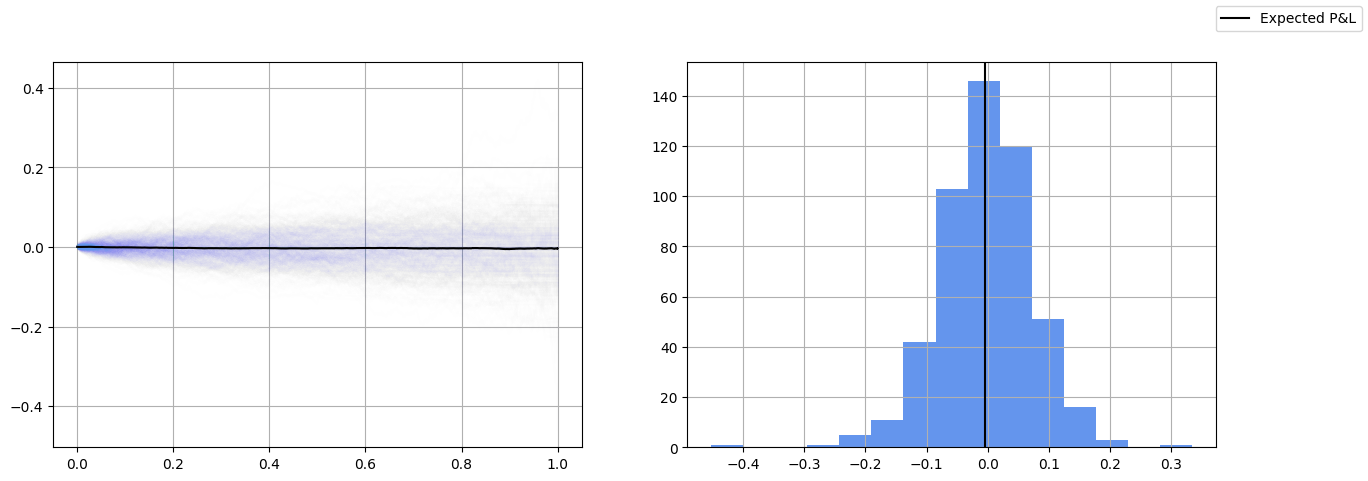

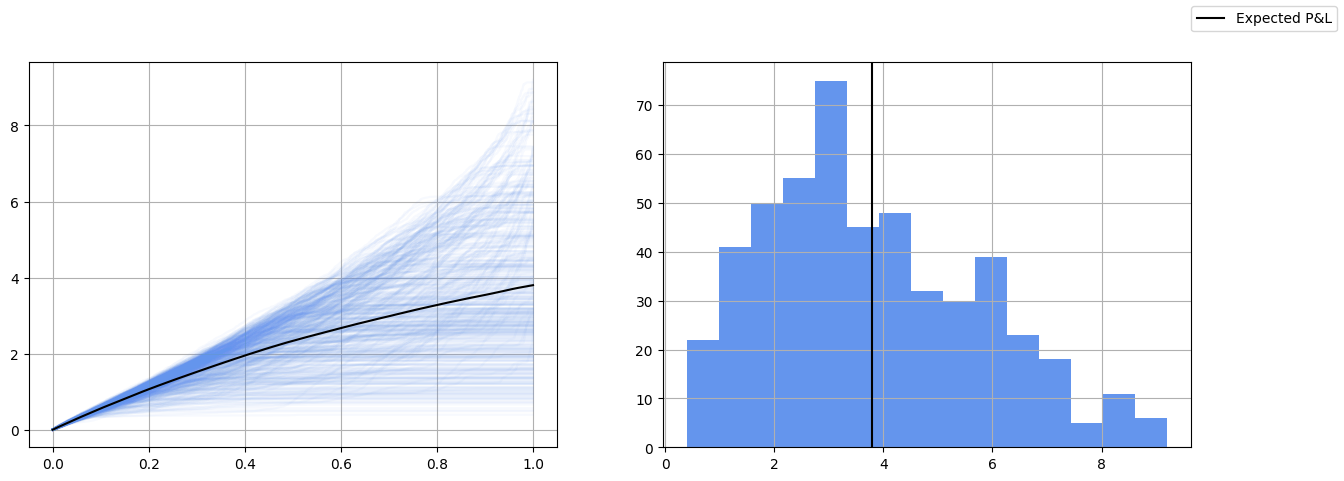

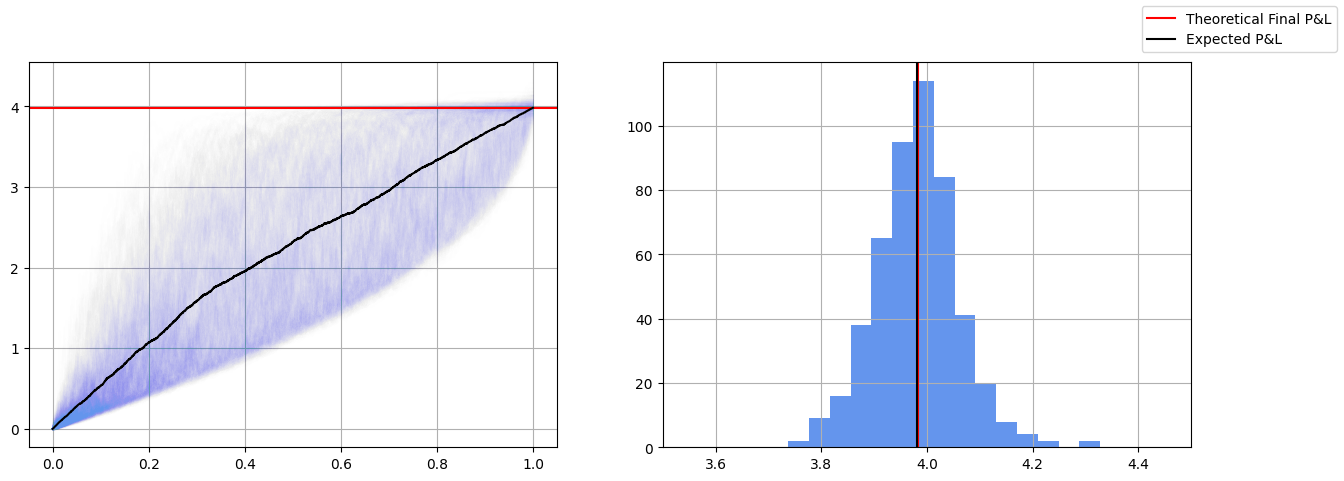

In [7]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
ax = axs[0]
final_results = []
pandl = []
for _ in range(500):
    S = S_0*simulate_gbm(T_years, SIMULATION_STEPS_IN_A_YEAR*T_years, mu, sigma, 1)[:, 0]
    Cs, deltas, gammas, hedge, cash_position = simulate_delta_hedging(S, delta_t, T_years, sigma, sigma, K, r)
    hedged_portfolio = Cs + hedge + cash_position
    final_results.append(hedged_portfolio[-1])
    pandl.append(hedged_portfolio)
    ax.plot(t, hedged_portfolio, color = "cornflowerblue", alpha = 0.005)
ax.plot(t, pd.DataFrame(pandl).mean(), color = "k")
ax.grid()
ax = axs[1]
pd.Series(final_results).hist(ax = ax, color = "cornflowerblue", bins = 15)
ax.axvline(pd.Series(final_results).mean(), color = "k", label = "Expected P&L")
f.legend()

f, axs = plt.subplots(1, 2, figsize = (15, 5))
ax = axs[0]
final_results = []
pandl = []
for _ in range(500):
    S = S_0*simulate_gbm(T_years, SIMULATION_STEPS_IN_A_YEAR*T_years, mu, sigma, 1)[:, 0]
    Cs, deltas, gammas, hedge, cash_position = simulate_delta_hedging(S, delta_t, T_years, 0.1, 0.1, K, r)
    hedged_portfolio = Cs + hedge + cash_position
    final_results.append(hedged_portfolio[-1])
    pandl.append(hedged_portfolio)
    ax.plot(t, hedged_portfolio, color = "cornflowerblue", alpha = 0.05)
# ax.axhline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r")
ax.plot(t, pd.DataFrame(pandl).mean(), color = "k")
ax.grid()
ax = axs[1]
pd.Series(final_results).hist(ax = ax, color = "cornflowerblue", bins = 15)
# ax.axvline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r", label = "Theoretical Final P&L")
ax.axvline(pd.Series(final_results).mean(), color = "k", label = "Expected P&L")
# ax.set_xlim(3.5, 4.5)
f.legend()

f, axs = plt.subplots(1, 2, figsize = (15, 5))
ax = axs[0]
final_results = []
pandl = []
for _ in range(500):
    S = S_0*simulate_gbm(T_years, SIMULATION_STEPS_IN_A_YEAR*T_years, mu, sigma, 1)[:, 0]
    Cs, deltas, gammas, hedge, cash_position = simulate_delta_hedging(S, delta_t, T_years, 0.1, sigma, K, r)
    hedged_portfolio = Cs + hedge + cash_position
    final_results.append(hedged_portfolio[-1])
    pandl.append(hedged_portfolio)
    ax.plot(t, hedged_portfolio, color = "cornflowerblue", alpha = 0.005)
ax.axhline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r")
ax.plot(t, pd.DataFrame(pandl).mean(), color = "k")
ax.grid()
ax = axs[1]
pd.Series(final_results).hist(ax = ax, color = "cornflowerblue", bins = 15)
ax.axvline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r", label = "Theoretical Final P&L")
ax.axvline(pd.Series(final_results).mean(), color = "k", label = "Expected P&L")
ax.set_xlim(3.5, 4.5)
f.legend()

/home/alebu/projects/stochastic_volatility/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  d_1 = (
/home/alebu/projects/stochastic_volatility/src/utils.py:20: RuntimeWarning: divide by zero encountered in divide
  d_2 = (
/home/alebu/projects/stochastic_volatility/src/utils.py:44: RuntimeWarning: invalid value encountered in divide
  return N_prime(d_1(S, K, T - t, r, sigma**2))/(S*sigma*np.sqrt(T - t))


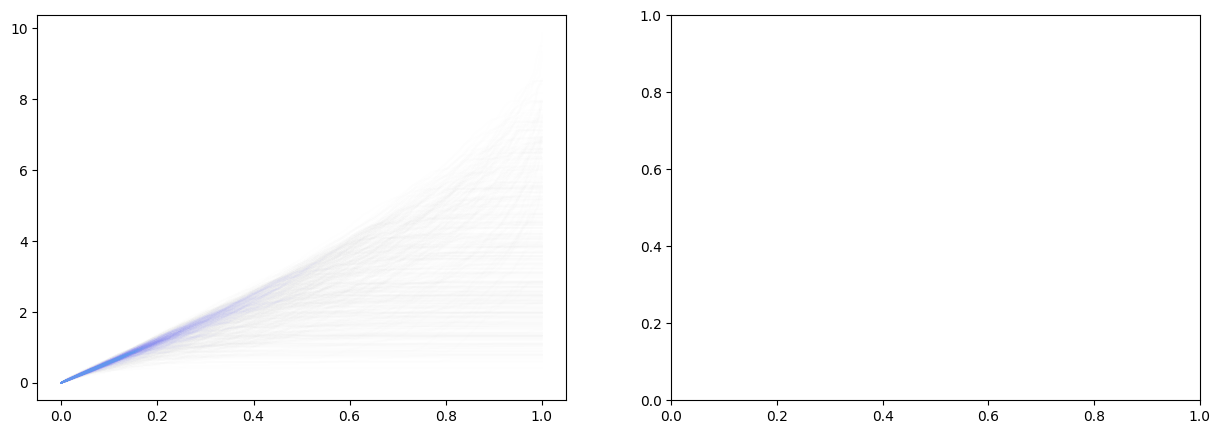

In [9]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
ax = axs[0]
final_results = []
pandl = []

day_10_portfolios = []
day_11_portfolios = []

day_10_S = []
day_10_gammas = []
# day_11_S = []

for _ in range(500):
    S = S_0*simulate_gbm(T_years, SIMULATION_STEPS_IN_A_YEAR*T_years, mu, sigma, 1)[:, 0]
    Cs, deltas, gammas, hedge, cash_position = simulate_delta_hedging(S, delta_t, T_years, 0.1, 0.1, K, r)
    hedged_portfolio = Cs + hedge + cash_position
    final_results.append(hedged_portfolio[-1])
    pandl.append(hedged_portfolio)
    ax.plot(t, hedged_portfolio, color = "cornflowerblue", alpha = 0.005)
    day_10_portfolios.append(hedged_portfolio[10])
    day_11_portfolios.append(hedged_portfolio[11])
    day_10_S.append(S[10])
    day_10_gammas.append(gammas[10])
# ax.plot(t, pd.DataFrame(pandl).mean(), color = "k")
# ax.grid()
# ax = axs[1]
# pd.Series(final_results).hist(ax = ax, color = "cornflowerblue", bins = 15)
# ax.axvline(pd.Series(final_results).mean(), color = "k", label = "Expected P&L")
# f.legend()

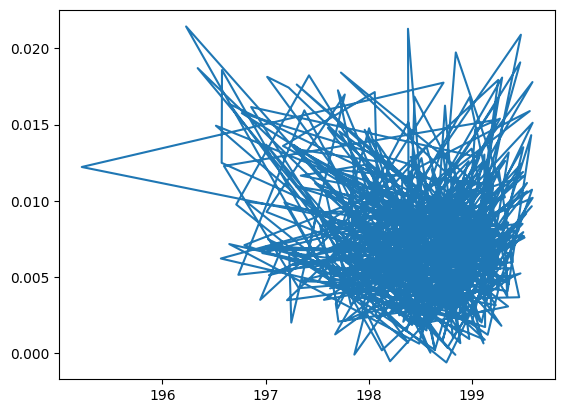

In [15]:
plt.plot(
    np.array(day_10_gammas)*np.array(day_10_S)**2, 
    np.array(day_11_portfolios)
)

/home/alebu/projects/stochastic_volatility/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  d_1 = (
/home/alebu/projects/stochastic_volatility/src/utils.py:20: RuntimeWarning: divide by zero encountered in divide
  d_2 = (


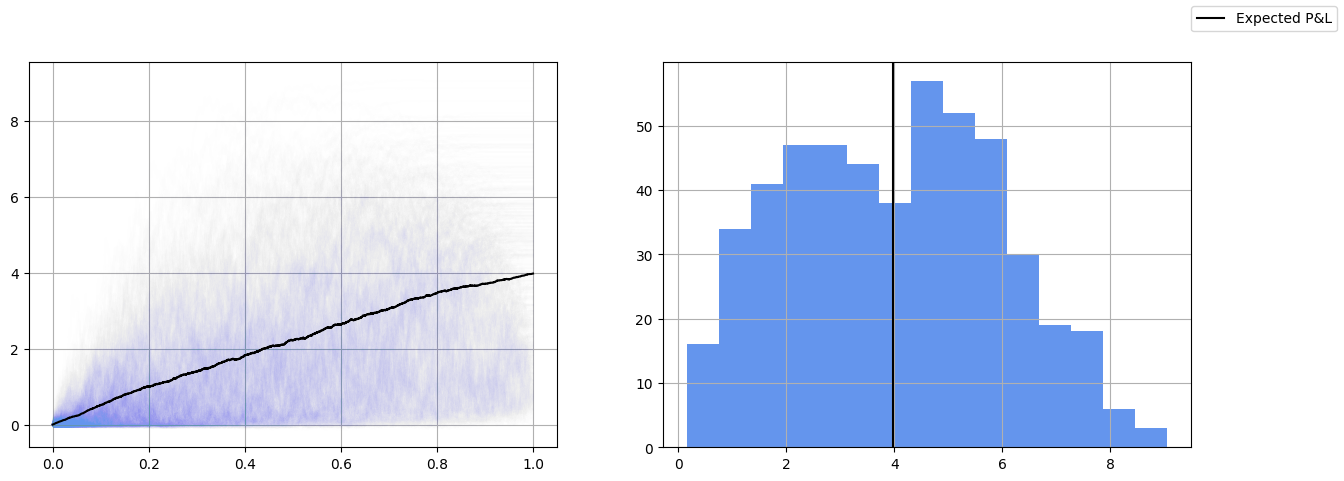

In [10]:

f, axs = plt.subplots(1, 2, figsize = (15, 5))
ax = axs[0]
final_results = []
pandl = []
for _ in range(500):
    S = S_0*simulate_gbm(T_years, SIMULATION_STEPS_IN_A_YEAR*T_years, mu, sigma, 1)[:, 0]
    Cs, deltas, hedge, cash_position = simulate_delta_hedging(S, delta_t, T_years, 0.1, 0.4, K, r)
    hedged_portfolio = Cs + hedge + cash_position
    final_results.append(hedged_portfolio[-1])
    pandl.append(hedged_portfolio)
    ax.plot(t, hedged_portfolio, color = "cornflowerblue", alpha = 0.005)
# ax.axhline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r")
ax.plot(t, pd.DataFrame(pandl).mean(), color = "k")
ax.grid()
ax = axs[1]
pd.Series(final_results).hist(ax = ax, color = "cornflowerblue", bins = 15)
# ax.axvline(call_option_bsm_formula(S, K, T_years, t, r, historical_vol(S, T_years))[0] - call_option_bsm_formula(S, K, T_years, t, r, 0.1)[0], color = "r", label = "Theoretical Final P&L")
ax.axvline(pd.Series(final_results).mean(), color = "k", label = "Expected P&L")
# ax.set_xlim(3.5, 4.5)
f.legend()

In what sense does the second method (i.e., hedging with implied vol) result in a deterministic P&L?